# Flann usage applied to AKAZE, ORB and SIFT descriptors

In [ ]:
from canon.utils import image_utils, notebook_utils

from canon.T1.process import feature_extraction
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Tuple
import time


def LowesRatio(matches : list[cv.DMatch]) -> list[cv.DMatch]:
    goodMatches = []
    for pair in matches:
        if len(pair) < 2:
            continue
        m, n = pair
        if m.distance < 0.75 * n.distance: 
            goodMatches.append(m)

    return goodMatches

def EvaluateFeatureMatcher(
        images : Tuple[cv.Mat, cv.Mat],
        descriptor,
        descriptorParams : dict,
        descriptorMatcher : cv.DescriptorMatcher,
        descriptorMatcherParams: Tuple
    ):
    kp1, des1 = descriptor(images[0], **descriptorParams)
    kp2, des2 = descriptor(images[1], **descriptorParams)

    matcher : cv.DescriptorMatcher = descriptorMatcher(*descriptorMatcherParams)

    matchesFound = matcher.knnMatch(des1, des2, 2)
    goodMatches = LowesRatio(matchesFound)

    style = dict(
        matchColor = (255, 0, 0), #Cor das linhas = vermelho
        singlePointColor = (0, 255, 0), #Cor dos pontos = verde
        flags = cv.DRAW_MATCHES_FLAGS_DEFAULT
    )
    res = cv.drawMatches(images[0], kp1, images[1], kp2, goodMatches, None, **style)

    return (matchesFound, goodMatches, res)
    

In [2]:

icPictures = image_utils.load_raw_images("FotosICMural")
img1 = icPictures["1"] #cv.cvtColor(icPictures["1"], cv.COLOR_BGR2RGB)
img2 = icPictures["2"] #cv.cvtColor(icPictures["2"], cv.COLOR_BGR2RGB)

FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH,
                    table_number=12,   # 12 is recommended
                    key_size=20,       # 20 is recommended
                    multi_probe_level=2) # 2 is recommended
# search_params = dict(checks=50)  # How many times the trees are recursively traversed
#https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html


binDescriptorFlannParams = (index_params, None)


/tmp/ipykernel_335160/152019935.py:16: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


ORB
Matches:	50000
GoodMatches:	4199
Ratio:	0.08398
Time elapsed:	7.433155059814453

AKAZE
Matches:	41068
GoodMatches:	5755
Ratio:	0.14013343722606408
Time elapsed:	10.338534593582153

SIFT
Matches:	157572
GoodMatches:	12785
Ratio:	0.08113751174066458
Time elapsed:	9.136198997497559



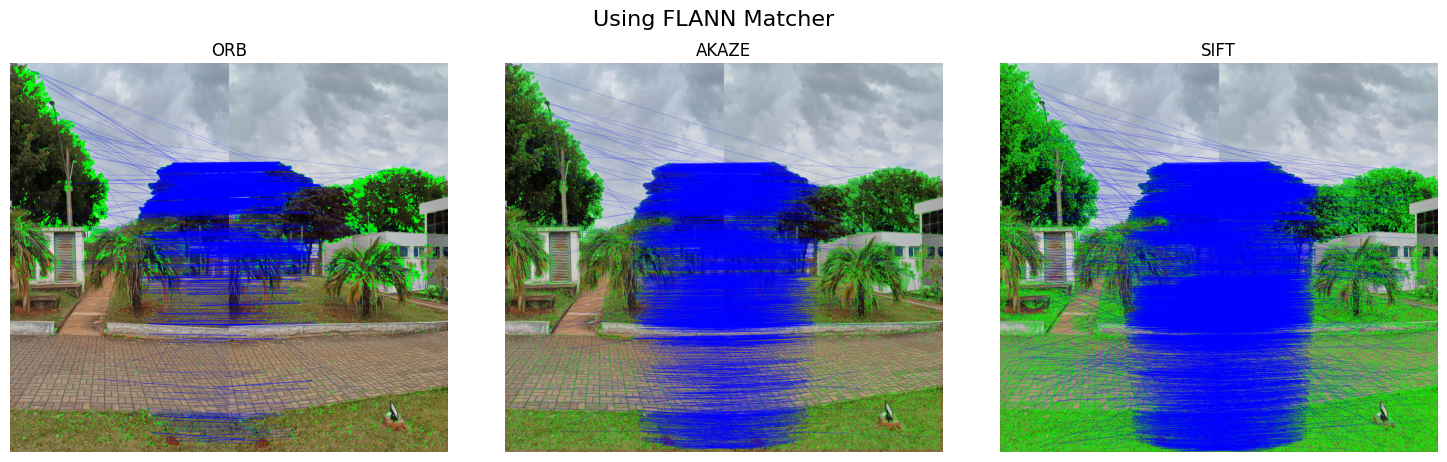

In [3]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, #Como o SIFT não é um descritor binário como os ORB e AKAZE, é preciso usar um algoritmo diferente da lib FLANN
                    trees=5)
search_params = dict(checks=50)  # How many times the trees are recursively traversed
siftParams = (index_params, search_params)

images = (img1, img2)
inputSuite = list([
    (images, feature_extraction.ORB, dict(nfeatures=50000), cv.FlannBasedMatcher, binDescriptorFlannParams),
    (images, feature_extraction.AKAZE, {}, cv.FlannBasedMatcher, binDescriptorFlannParams),
    (images, feature_extraction.SIFT, {}, cv.FlannBasedMatcher, siftParams)
])

fig, axes = plt.subplots(1, len(inputSuite), figsize=(15, 5), constrained_layout=True)
fig.suptitle("Using FLANN Matcher", fontsize=16)
fig.tight_layout()
for i, item in enumerate(inputSuite):
    descrName = item[1].__name__
    matcherName = item[3].__name__

    timerStart = time.time()
    allMatches, goodMatches, arrowView = EvaluateFeatureMatcher(*item)
    timerEnd = time.time()

    print(f"{descrName}\n" +
    f"Matches:\t{len(allMatches)}\n" +
    f"GoodMatches:\t{len(goodMatches)}\n" +
    f"Ratio:\t{len(goodMatches)/len(allMatches)}\n"
    f"Time elapsed:\t{timerEnd - timerStart}\n"
    )

    image_utils.save_image(arrowView, path= "interim/ComparingMatchers", filename= f"{descrName}-{matcherName}-pair")
    # image_utils.save_image(arrowView, f"{descrName}-{matcherName}-pair")
    axes[i].set_title(descrName)
    axes[i].imshow(cv.cvtColor(arrowView, cv.COLOR_BGR2RGB))
    axes[i].axis("off")
    

plt.show()

ORB
Matches:	50000
GoodMatches:	679
Ratio:	0.01358
Time elapsed:	9.362594366073608

AKAZE
Matches:	41068
GoodMatches:	2219
Ratio:	0.05403233661244765
Time elapsed:	14.349544525146484

SIFT
Matches:	157572
GoodMatches:	13756
Ratio:	0.08729977407153555
Time elapsed:	290.76736879348755



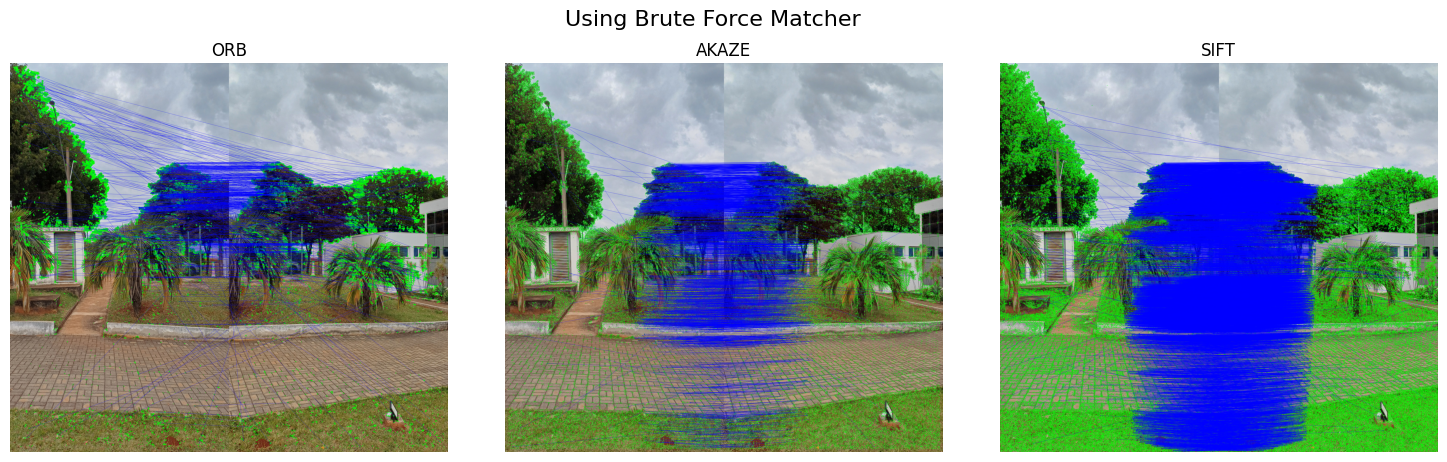

In [5]:
inputSuite = list([
    (images, feature_extraction.ORB, dict(nfeatures=50000), cv.BFMatcher, ()),
    (images, feature_extraction.AKAZE, {}, cv.BFMatcher, ()),
    (images, feature_extraction.SIFT, {}, cv.BFMatcher, ())
])

fig, axes = plt.subplots(1, len(inputSuite), figsize=(15, 5))
fig.suptitle("Using Brute Force Matcher", fontsize=16)
fig.tight_layout()
for i, item in enumerate(inputSuite):
    descrName = item[1].__name__
    matcherName = item[3].__name__

    timerStart = time.time()
    allMatches, goodMatches, arrowView = EvaluateFeatureMatcher(*item)
    timerEnd = time.time()

    print(f"{descrName}\n" +
    f"Matches:\t{len(allMatches)}\n" +
    f"GoodMatches:\t{len(goodMatches)}\n" +
    f"Ratio:\t{len(goodMatches)/len(allMatches)}\n"
    f"Time elapsed:\t{timerEnd - timerStart}\n"
    )

    image_utils.save_image(arrowView, path= "interim/ComparingMatchers", filename= f"{descrName}-{matcherName}-pair")
    axes[i].set_title(descrName)
    axes[i].imshow(cv.cvtColor(arrowView, cv.COLOR_BGR2RGB))
    axes[i].axis("off")
    
plt.show()